### This notebook includes the entire pipeline for the analysis after the necessary preprocessing that creates a (2040, 2639) feature matrix. At a high level, this notebook tunes a given classifier for predicting whether a speech recording is indicative of a speech disorder (0: Benign, 1: Anomalous). Then, the tuned classifier is used to predict instances within the test (hold out) set. ROC curves, Precision, Recall, and F-1 scores are also calculated outside of accuracy. Lastly, we interpret the constructed model through permutation importance, shapley importance, and partial dependency plots.

### Note: The results of the RCEFV with a simple random forests classifier are not shown here (a simple subset is created based on the results in the second code cell), although the process was a straightforward recursive feature elimination using a random forests model with default hyperparameters and step size of 1. Additionally, feature pruning based on correlation is conducted only to better improve interpretability (e.g., permutation feature importance is heavily influenced by highly correlated features). This additional reduction of features based on collinearity allows for better interpretability of the model at the cost of a slight predictive capability decrease.

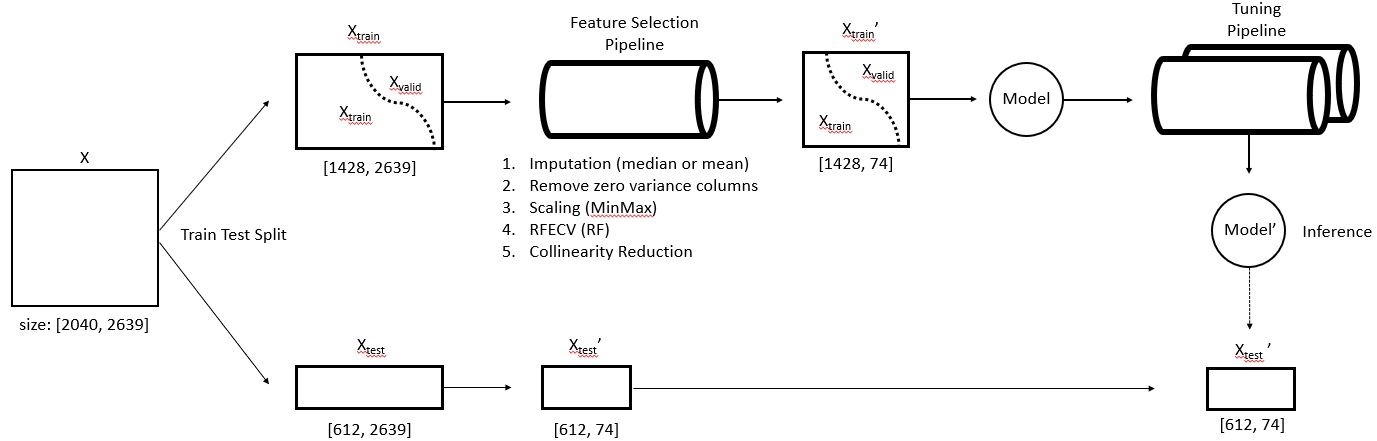

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, RFECV
from sklearn.metrics import accuracy_score, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from pylab import rcParams
from sklearn.impute import KNNImputer

rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300
rcParams['font.size'] = 10

#### Read in data, and then subset based on RFECV results using a default RandomForestClassifier(). Import data and drop a few features.

In [2]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['y','age','sex','recording_num'], axis = 1)
num_feats_prior = X.shape[1]

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]
num_feats_after = X.shape[1]
print('Total number of features dropped was... ', num_feats_prior - num_feats_after, '\nRemaining features... ', num_feats_after)

Total number of features dropped was...  2535 
Remaining features...  104


#### Assess correlation between features, and drop individual features if they correlate highly (r > .75 chosen here) with any other features.

In [3]:
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])

Total number of features dropped was... 29 
Remaining features...  75


In [4]:
X = X.drop('high_indexphrase_features', axis = 1)

In [5]:
X.columns = ['Stdev Period l-a', 'Stdev MFCC-7 l-a', 'Mean Slope Melspec l-a', 'Mean Harmonicity l-a', 'Jitter (loc) h-a',
'Mean Slope Melspec h-a', 'Jitter (rap) lhl-a', 'Mean MFCC-2 lhl-a', 'Mean MFCC-7 lhl-a', 
'Stdev MFCC-2 lhl-a', 'Stdev Onset Envelope lhl-a', 'Stdev Pitches lhl-a', 'Mean Frequency n-a',
'Mean MFCC-8 n-a', 'LPC-1 n-a', 'Mean Slope Melspec n-a', 'Spec Power 1000Hz .25s n-a',
'Jitter (loc) l-i', 'Shimmer (apq11) l-i', 'Mean Magnitudes l-i', 'Mean Chromagram-4 l-i', 'Stdev Chromagram-4 l-i',
'Mean Slope (Hz) l-i', 'Mean MFCC-6 h-i', 'Mean Magnitudes h-i', 'Mean Slope (Hz) h-i', 'Mean MFCC-9 lhl-i',
'Mean Magnitudes lhl-i', 'Mean Harmony lhl-i', 'Mean Chromagram-0 n-i', 'Mean Slope Melspec n-i', 'Stdev Period l-u',
'Mean MFCC-4 l-u', 'Mean Slope (Hz) l-u', 'Mean Slope Melspec h-u', 'Mean MFCC-4 lhl-u', 'Mean Onset Envelope lhl-u',
'Stdev MFCC Delta-5 lhl-u', 'Stdev MFCC Delta-10 lhl-u', 'Stdev Period n-u', 'Mean Slope (Hz) n-u', 'HNR Phrases',
'Count of Periods Phrases', 'Mean MFCC-2 Phrases', 'Mean MFCC Delta-3 Phrases', 'Mean MFCC Delta-4 Phrases', 
'Mean MFCC Delta-11 Phrases', 'Stdev MFCC-2 Phrases', 'Stdev Onset Envelope Phrases', 'Max RMS Phrases',
'Stdev MFCC Delta-3 Phrases', 'Stdev MFCC Delta-7 Phrases', 'Spec Power 1000Hz .25s Phrases',
'Spec Power 1000Hz .5s Phrases','Spec Power 1000Hz .75s Phrases', 'CPPS Phrases', 'LSF-0 l-a', 
'Spectral Flux Stdev lhl-a', 'Spectral Spread Mean lhl-a', 'Spectral Spread Mean n-i',
'Shannon Entropy Sliding Window First Deriv Stdev n-i', 'f2 l-i', 'Spectral Skewness Mean h-i', 'Crest Factor Mean n-u',
'Pitch Period Entropy l-u', 'Spectral Flux First Deriv Mean Phrases', 'Spectral Entropy First Deriv Stdev Phrases',
'Spectral Spread Mean Phrases', 'Spectral Skewness First Deriv Stdev Phrases', 'Spectral Flatness Stdev Phrases', 
'Spectral Rolloff Stdev Phrases', 'Pitch Period Entropy Phrases', 'LPC-4 Phrases', 'Kurtosis Sliding Window First Deriv Mean Phrases']

#### Split data and conduct an initial fit prior to hyperparameter tuning.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

classifier = GradientBoostingClassifier()

test_pipeline = Pipeline([('variance_pruning', VarianceThreshold()),
                ('imputer', KNNImputer()), 
                ('scaler', MinMaxScaler()),
                ('model', classifier)])

test_pipeline.fit(X_train, y_train)
print(classification_report(y_test, test_pipeline.predict(X_test), target_names = ['benign','anomalous'], digits = 4))

              precision    recall  f1-score   support

      benign     0.7540    0.6845    0.7176       206
   anomalous     0.8471    0.8867    0.8664       406

    accuracy                         0.8186       612
   macro avg     0.8005    0.7856    0.7920       612
weighted avg     0.8157    0.8186    0.8163       612



#### Conducted hyperparameter tuning using RandomizedSearchCV and the already constructed pipeline. 

In [10]:
search_space = [{'model': [GradientBoostingClassifier()], # best parameters for the gbc
                 'model__criterion': ['mse'], 
                 'model__n_estimators': [175],
                 'model__max_depth': [5],
                 'model__min_samples_leaf': [5]}]

clf = RandomizedSearchCV(test_pipeline, search_space, cv = 5, verbose = 0, n_jobs = -1,\
                        scoring = 'roc_auc', n_iter = 50) 

clf = clf.fit(X_train, y_train) 

print('Best score of a given tuned classifier during the randomized search...', clf.best_score_*100)

C:\Users\esabic\Anaconda3\envs\gpu_environment\lib\site-packages\sklearn\model_selection\_search.py:289: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best score of a given tuned classifier during the randomized search... 88.50943809026192


#### Fetch best estimator found during the tuning process, and finally use this estimator to predict cases in the testing set. Calculate precision, recall, and f1-score across the two classes.

In [11]:
tuned_clf = clf.best_estimator_

print(classification_report(y_test, tuned_clf.predict(X_test), target_names = ['benign','anomalous'], digits = 4))
print(accuracy_score(y_test, tuned_clf.predict(X_test)))

              precision    recall  f1-score   support

      benign     0.7737    0.7136    0.7424       206
   anomalous     0.8602    0.8941    0.8768       406

    accuracy                         0.8333       612
   macro avg     0.8169    0.8038    0.8096       612
weighted avg     0.8311    0.8333    0.8316       612

0.8333333333333334


In [13]:
print(clf.best_params_)

{'model__n_estimators': 175, 'model__min_samples_leaf': 5, 'model__max_depth': 5, 'model__criterion': 'mse', 'model': GradientBoostingClassifier(criterion='mse', max_depth=5, min_samples_leaf=5,
                           n_estimators=175)}


#### Create a receiver operating characteristic (ROC) curve and derive area under the curve (AUC).

C:\Users\esabic\Anaconda3\envs\gpu_environment\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

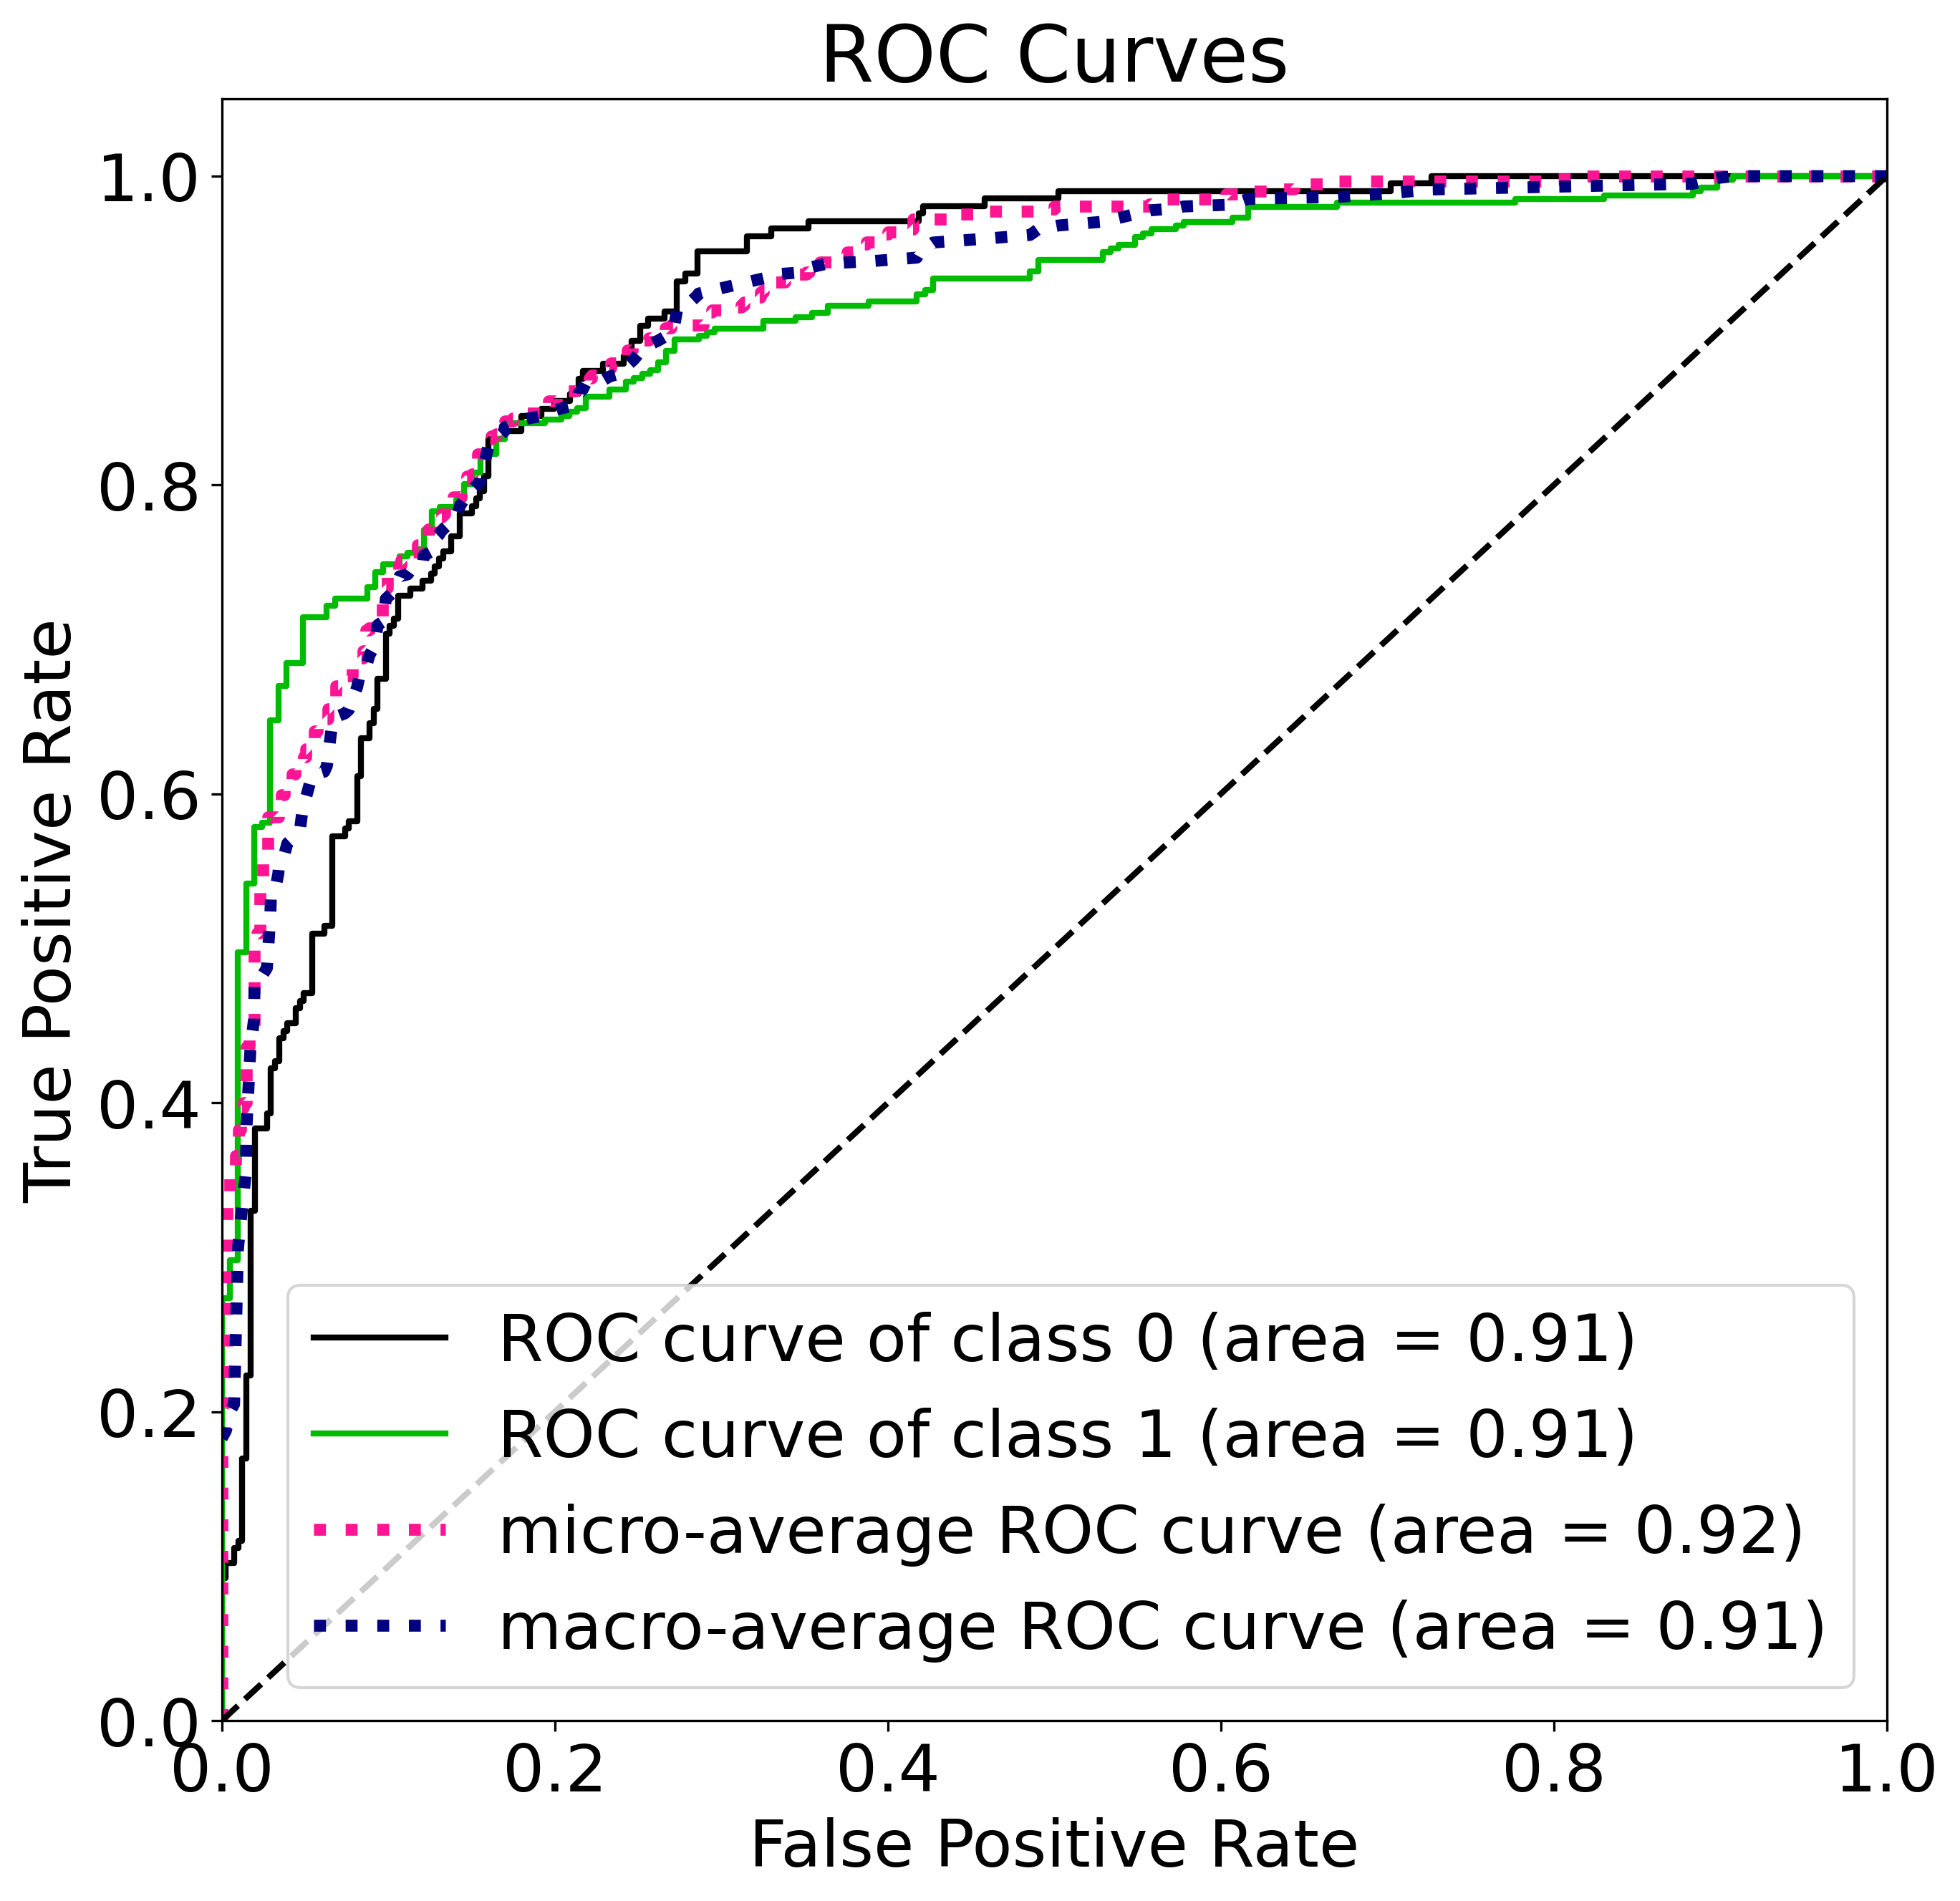

In [14]:
import sklearn.metrics as metrics
import scikitplot as skplt
import matplotlib.pyplot as plt

rcParams['font.size'] = 22

y_true = y_test
y_probas = tuned_clf.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show

#### Conduct permutation importance, Shapley-based importance, and create partial dependency plots using the highly influential features.

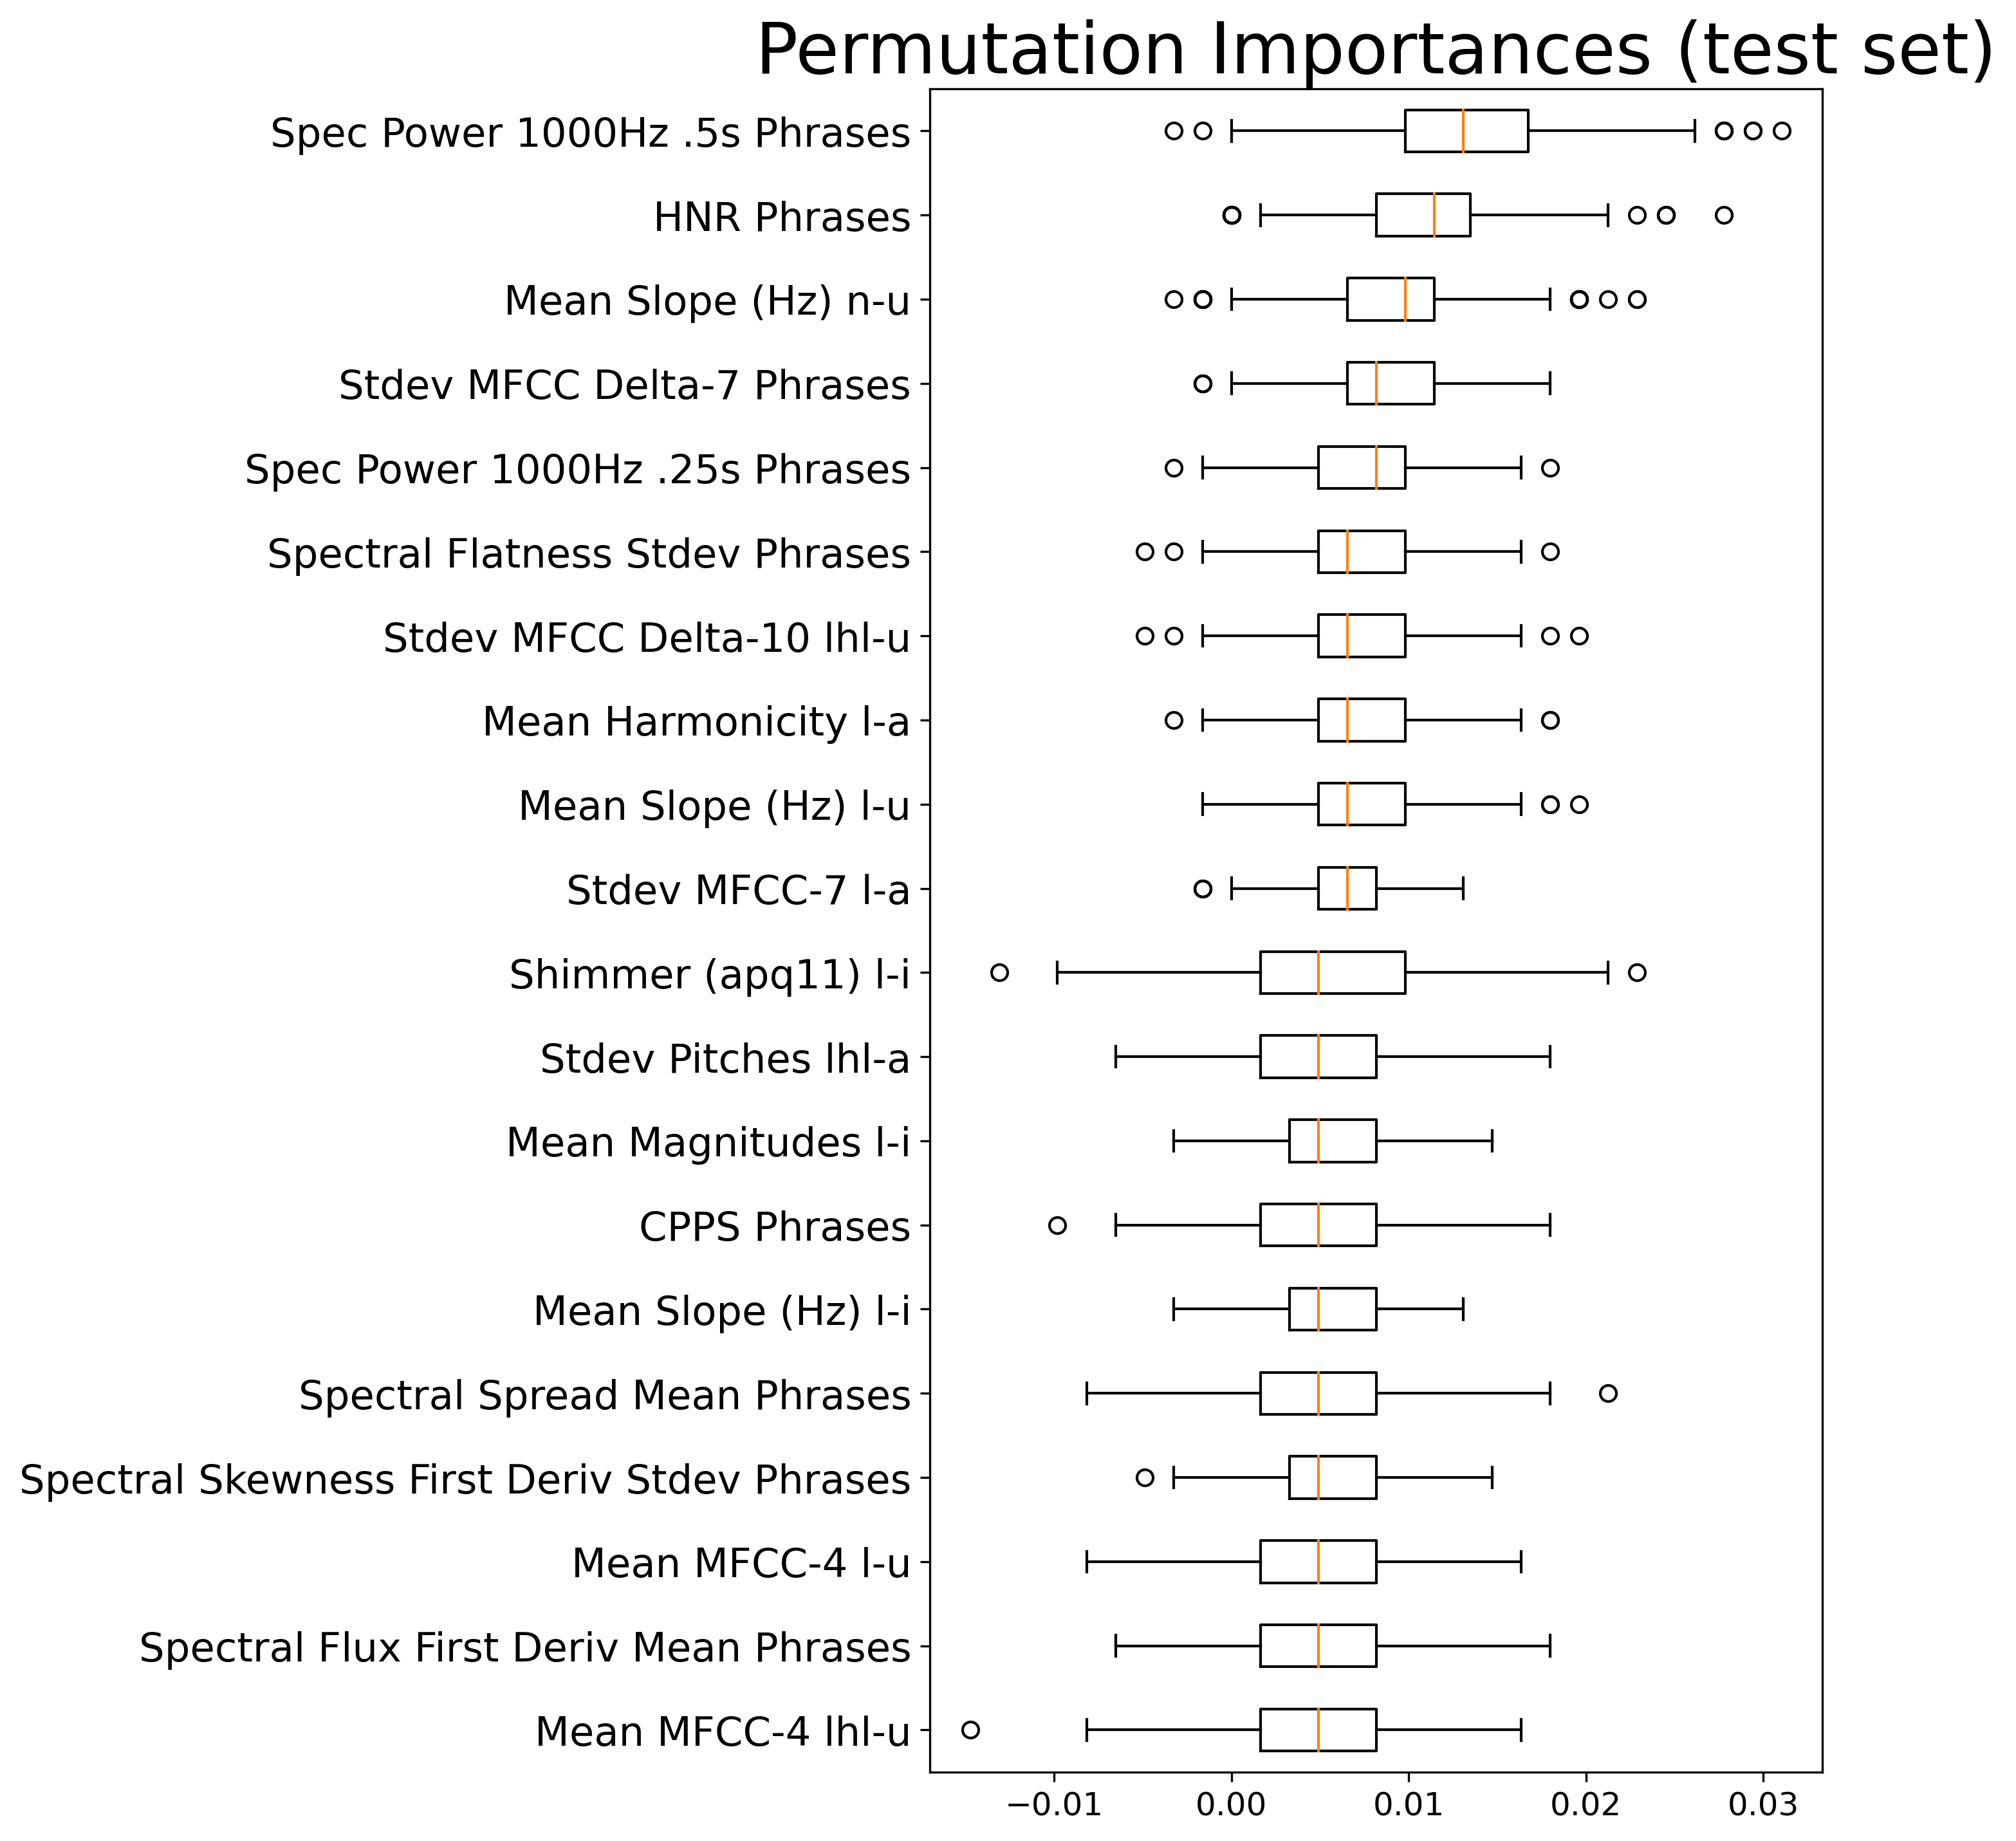

In [15]:
import matplotlib
from sklearn.inspection import permutation_importance

matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=15) 

result = permutation_importance(tuned_clf, X_test, y_test, n_repeats = 500, 
                                random_state = 42, n_jobs = -1)

sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots()

ax.boxplot(result.importances[sorted_idx][-20:].T,
           vert=False, labels=X_test.columns[sorted_idx][-20:])

ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

#### Shap Feature Importance here.

Permutation explainer: 613it [00:29, 15.22it/s]                                                                        


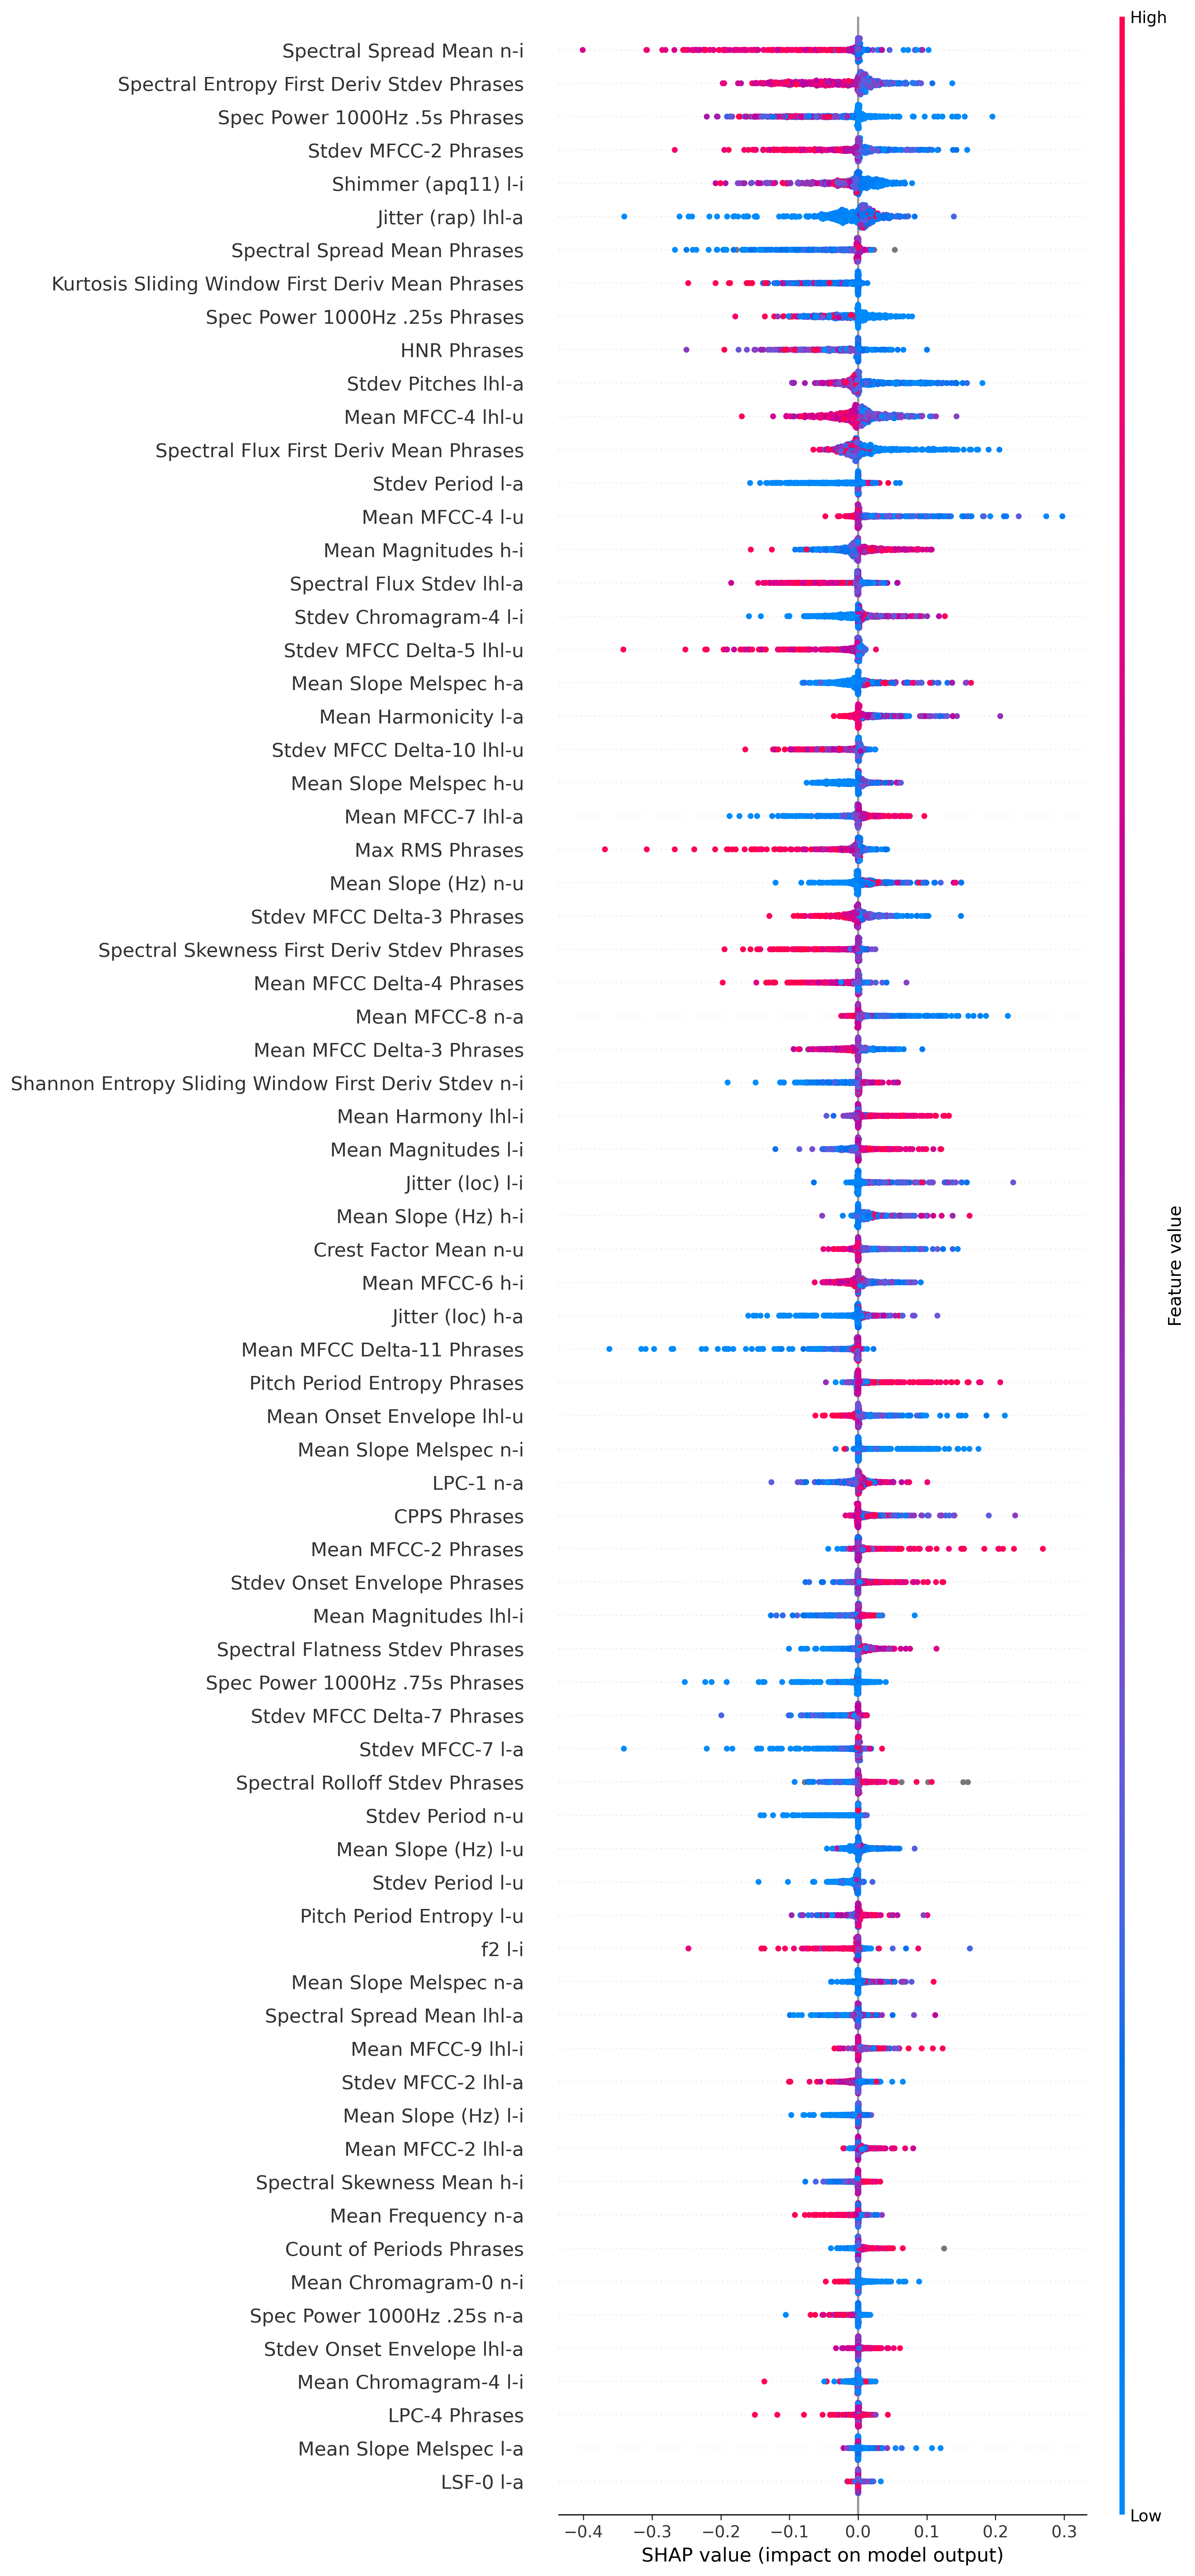

In [16]:
import shap

f = lambda x: tuned_clf.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test.iloc[:,:])

shap.plots.beeswarm(shap_values)

#### Limit amount of features shown in the plot.

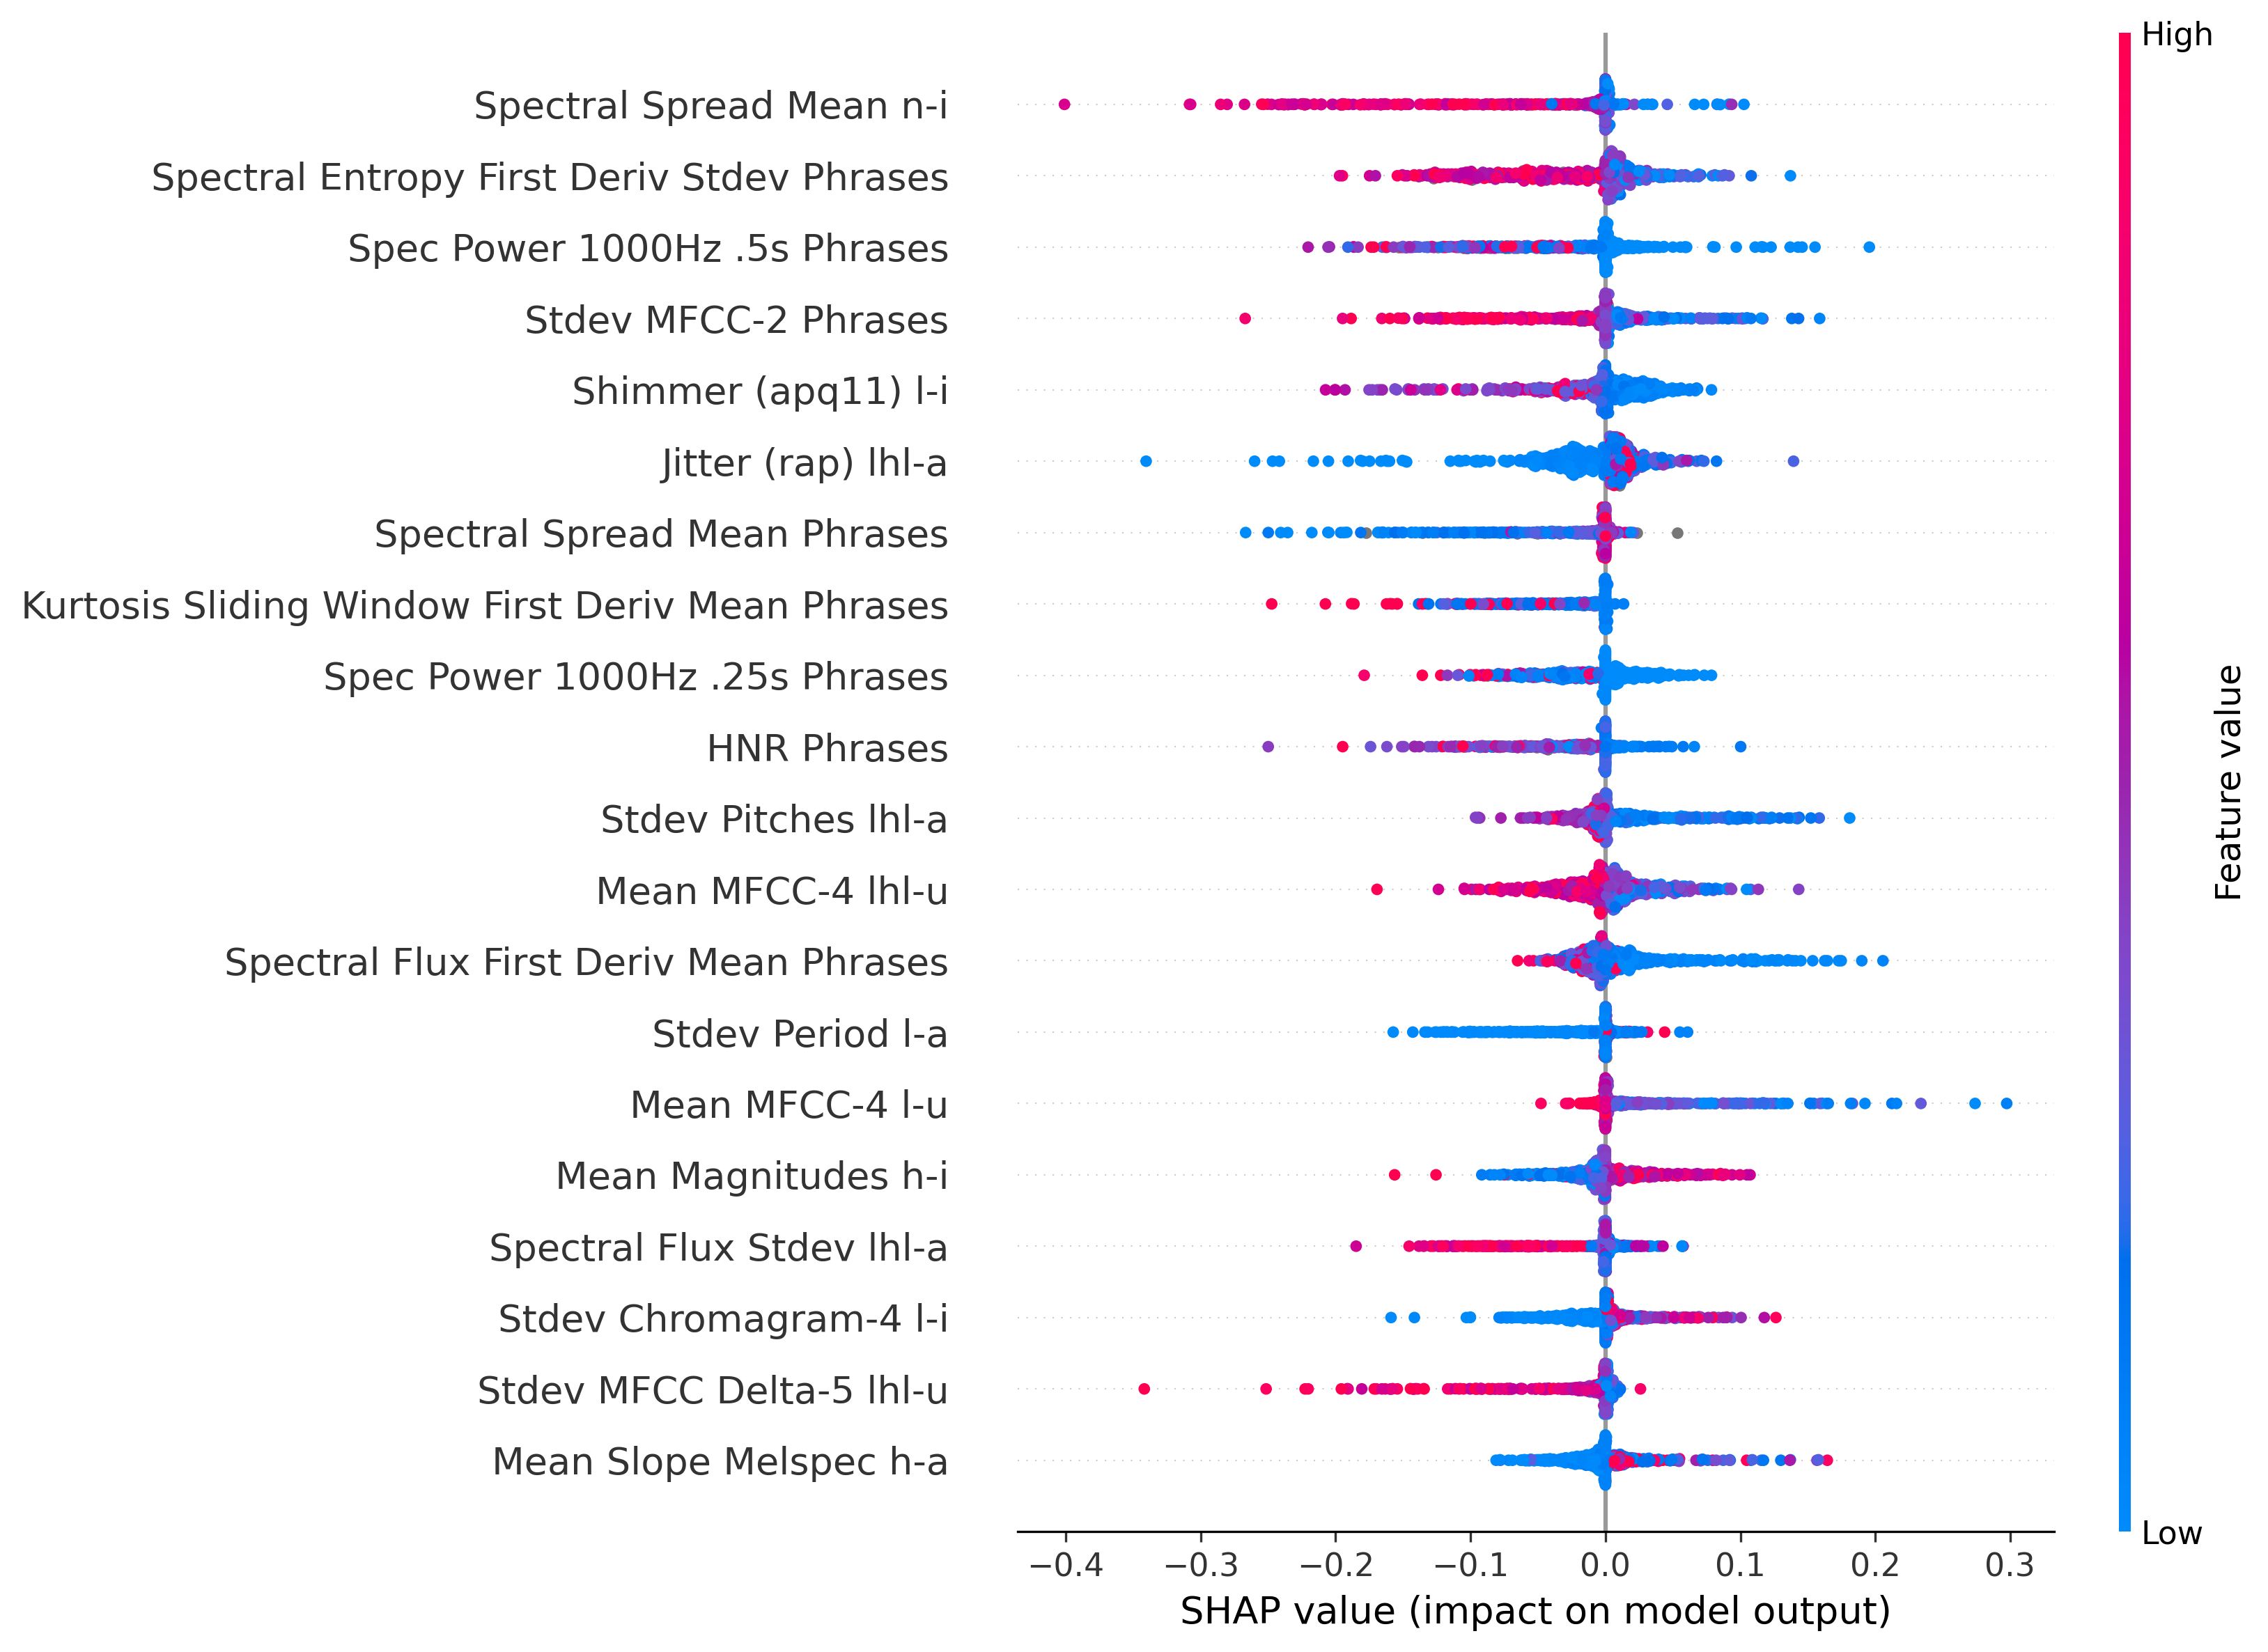

In [17]:
top = ['Spectral Spread Mean n-i', 'Spectral Entropy First Deriv Stdev Phrases', 'Spec Power 1000Hz .5s Phrases',
      'Stdev MFCC-2 Phrases', 'Shimmer (apq11) l-i', 'Jitter (rap) lhl-a', 'Spectral Spread Mean Phrases',
      'Kurtosis Sliding Window First Deriv Mean Phrases', 'Spec Power 1000Hz .25s Phrases', 'HNR Phrases',
      'Stdev Pitches lhl-a', 'Mean MFCC-4 lhl-u', 'Spectral Flux First Deriv Mean Phrases', 'Stdev Period l-a',
      'Mean MFCC-4 l-u', 'Mean Magnitudes h-i', 'Spectral Flux Stdev lhl-a', 'Stdev Chromagram-4 l-i',
      'Stdev MFCC Delta-5 lhl-u', 'Mean Slope Melspec h-a']

top_loc=[X.columns.get_loc(c) for c in top if c in X]
shap.plots.beeswarm(shap_values[:,top_loc])

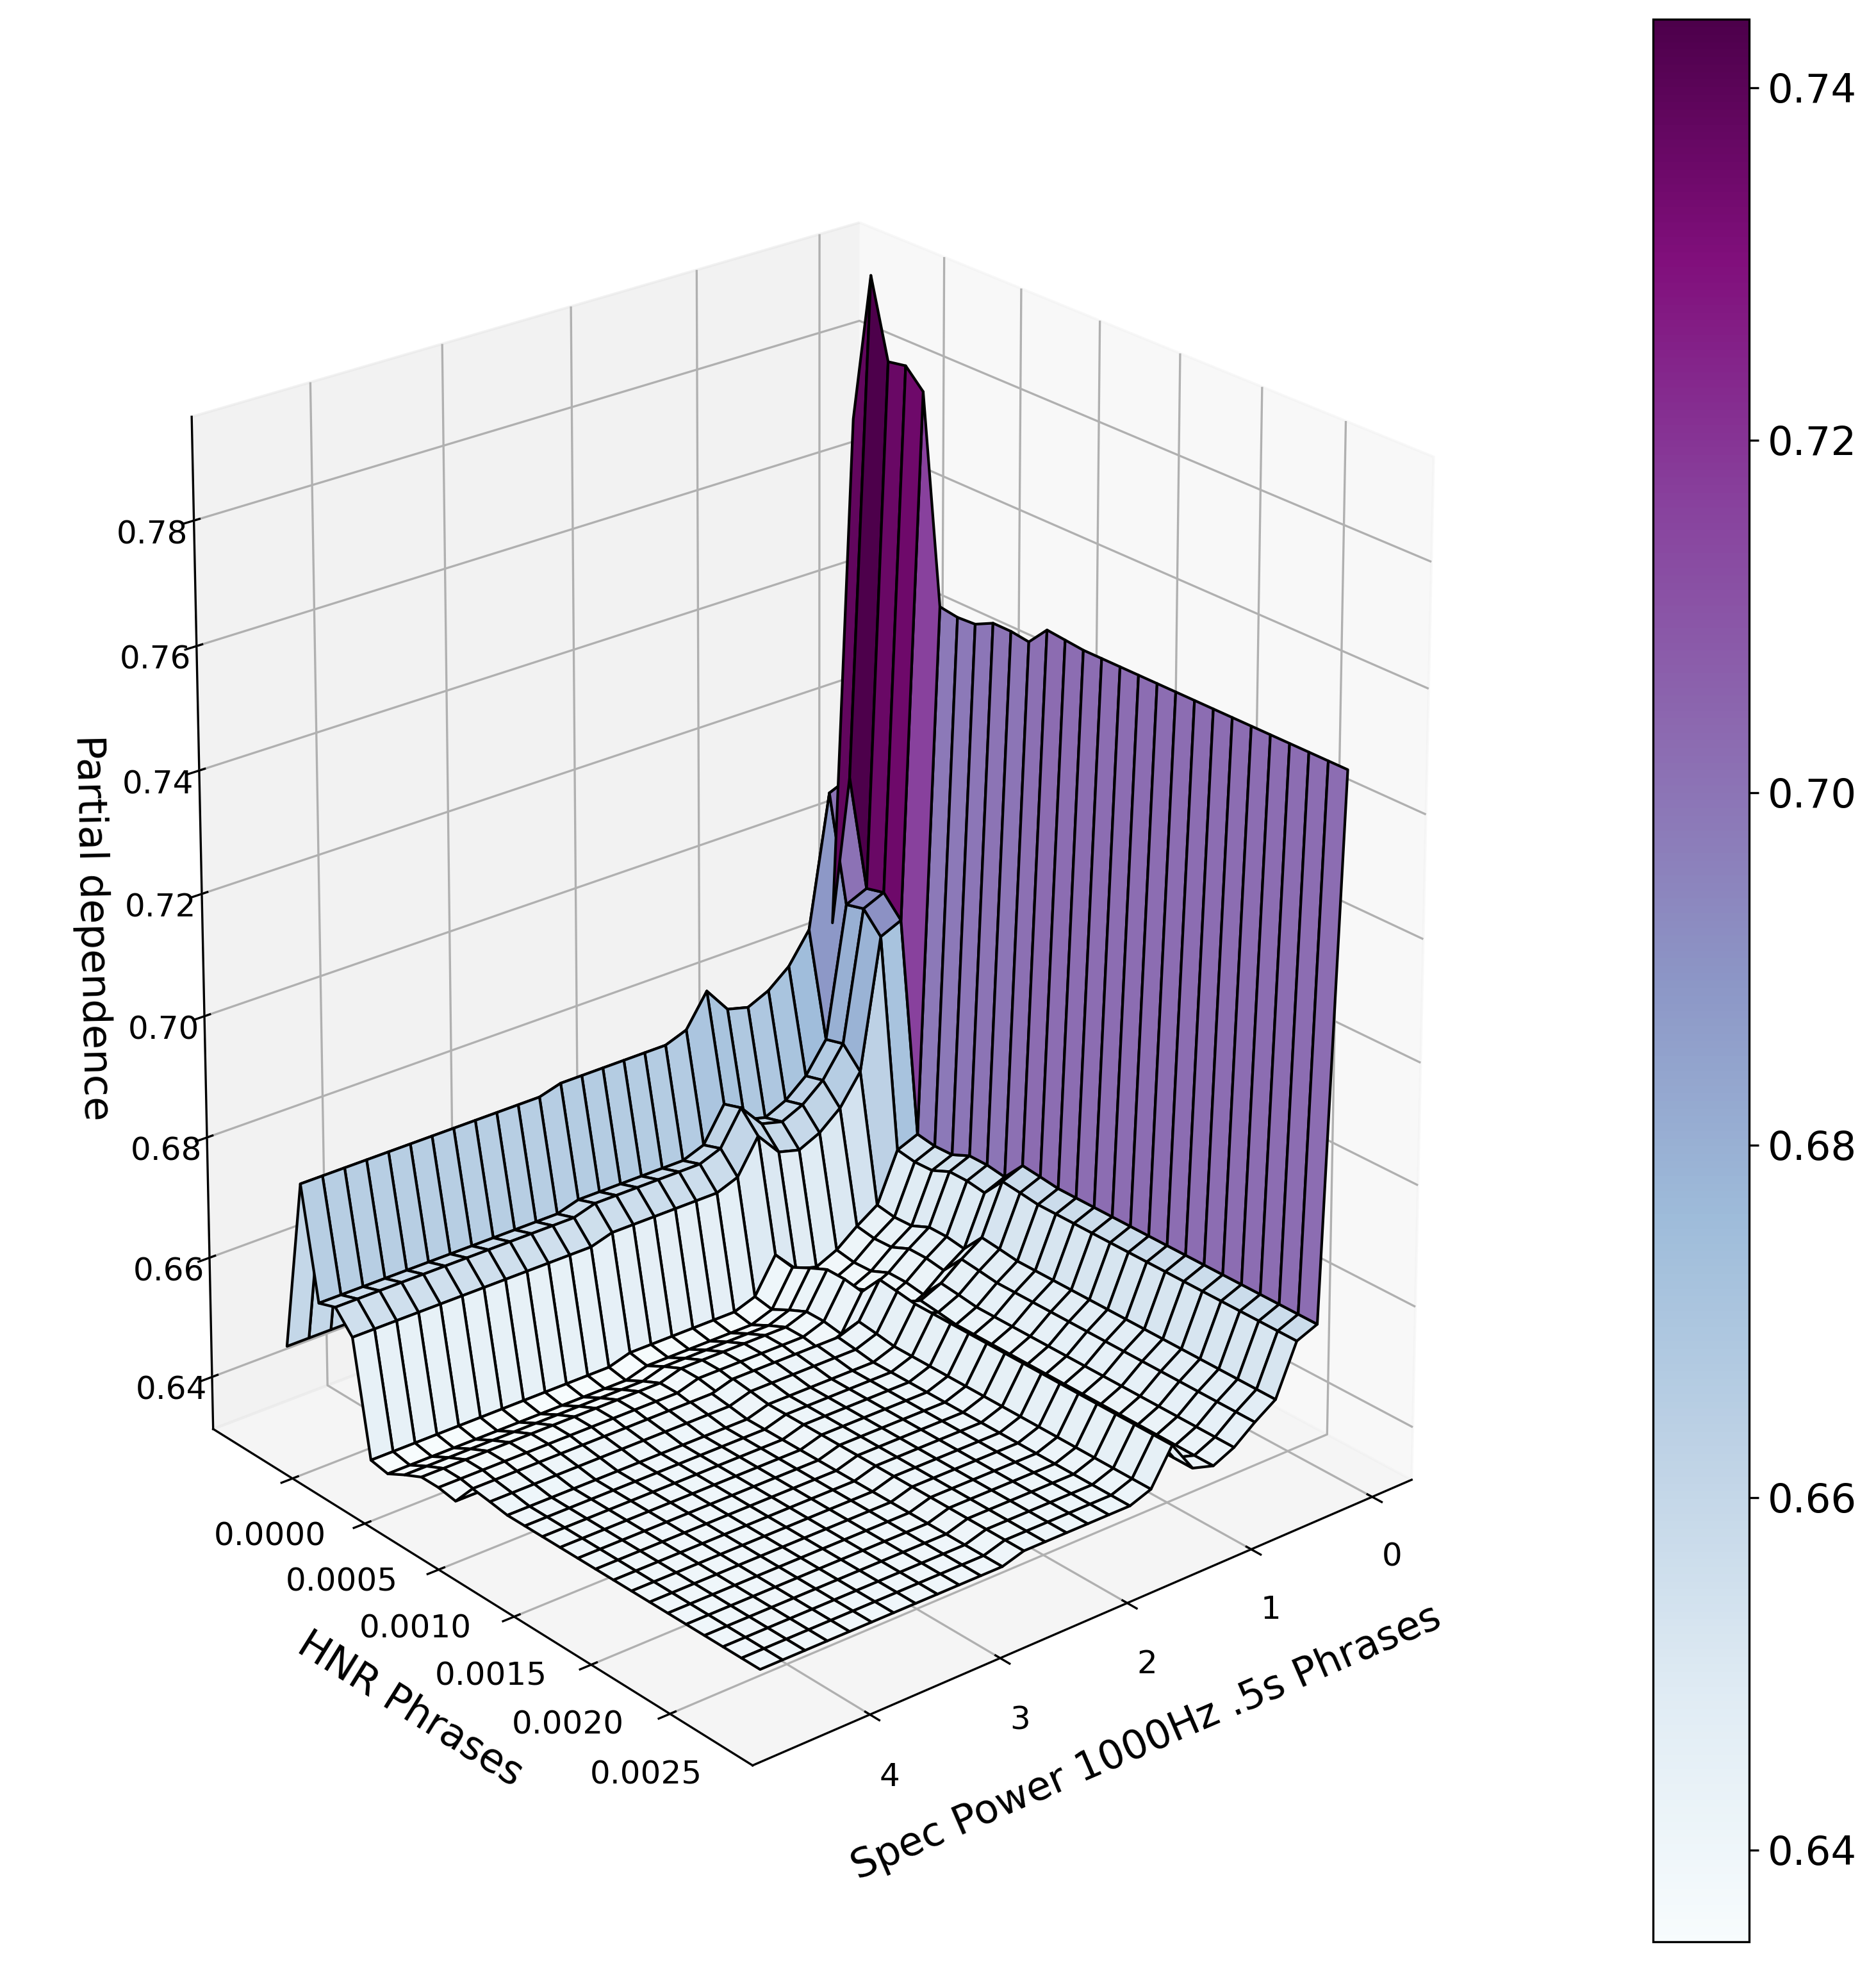

In [21]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Spec Power 1000Hz .5s Phrases', 'HNR Phrases')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

#ax.view_init(elev=20, azim=122)
ax.view_init(elev=20, azim=50)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

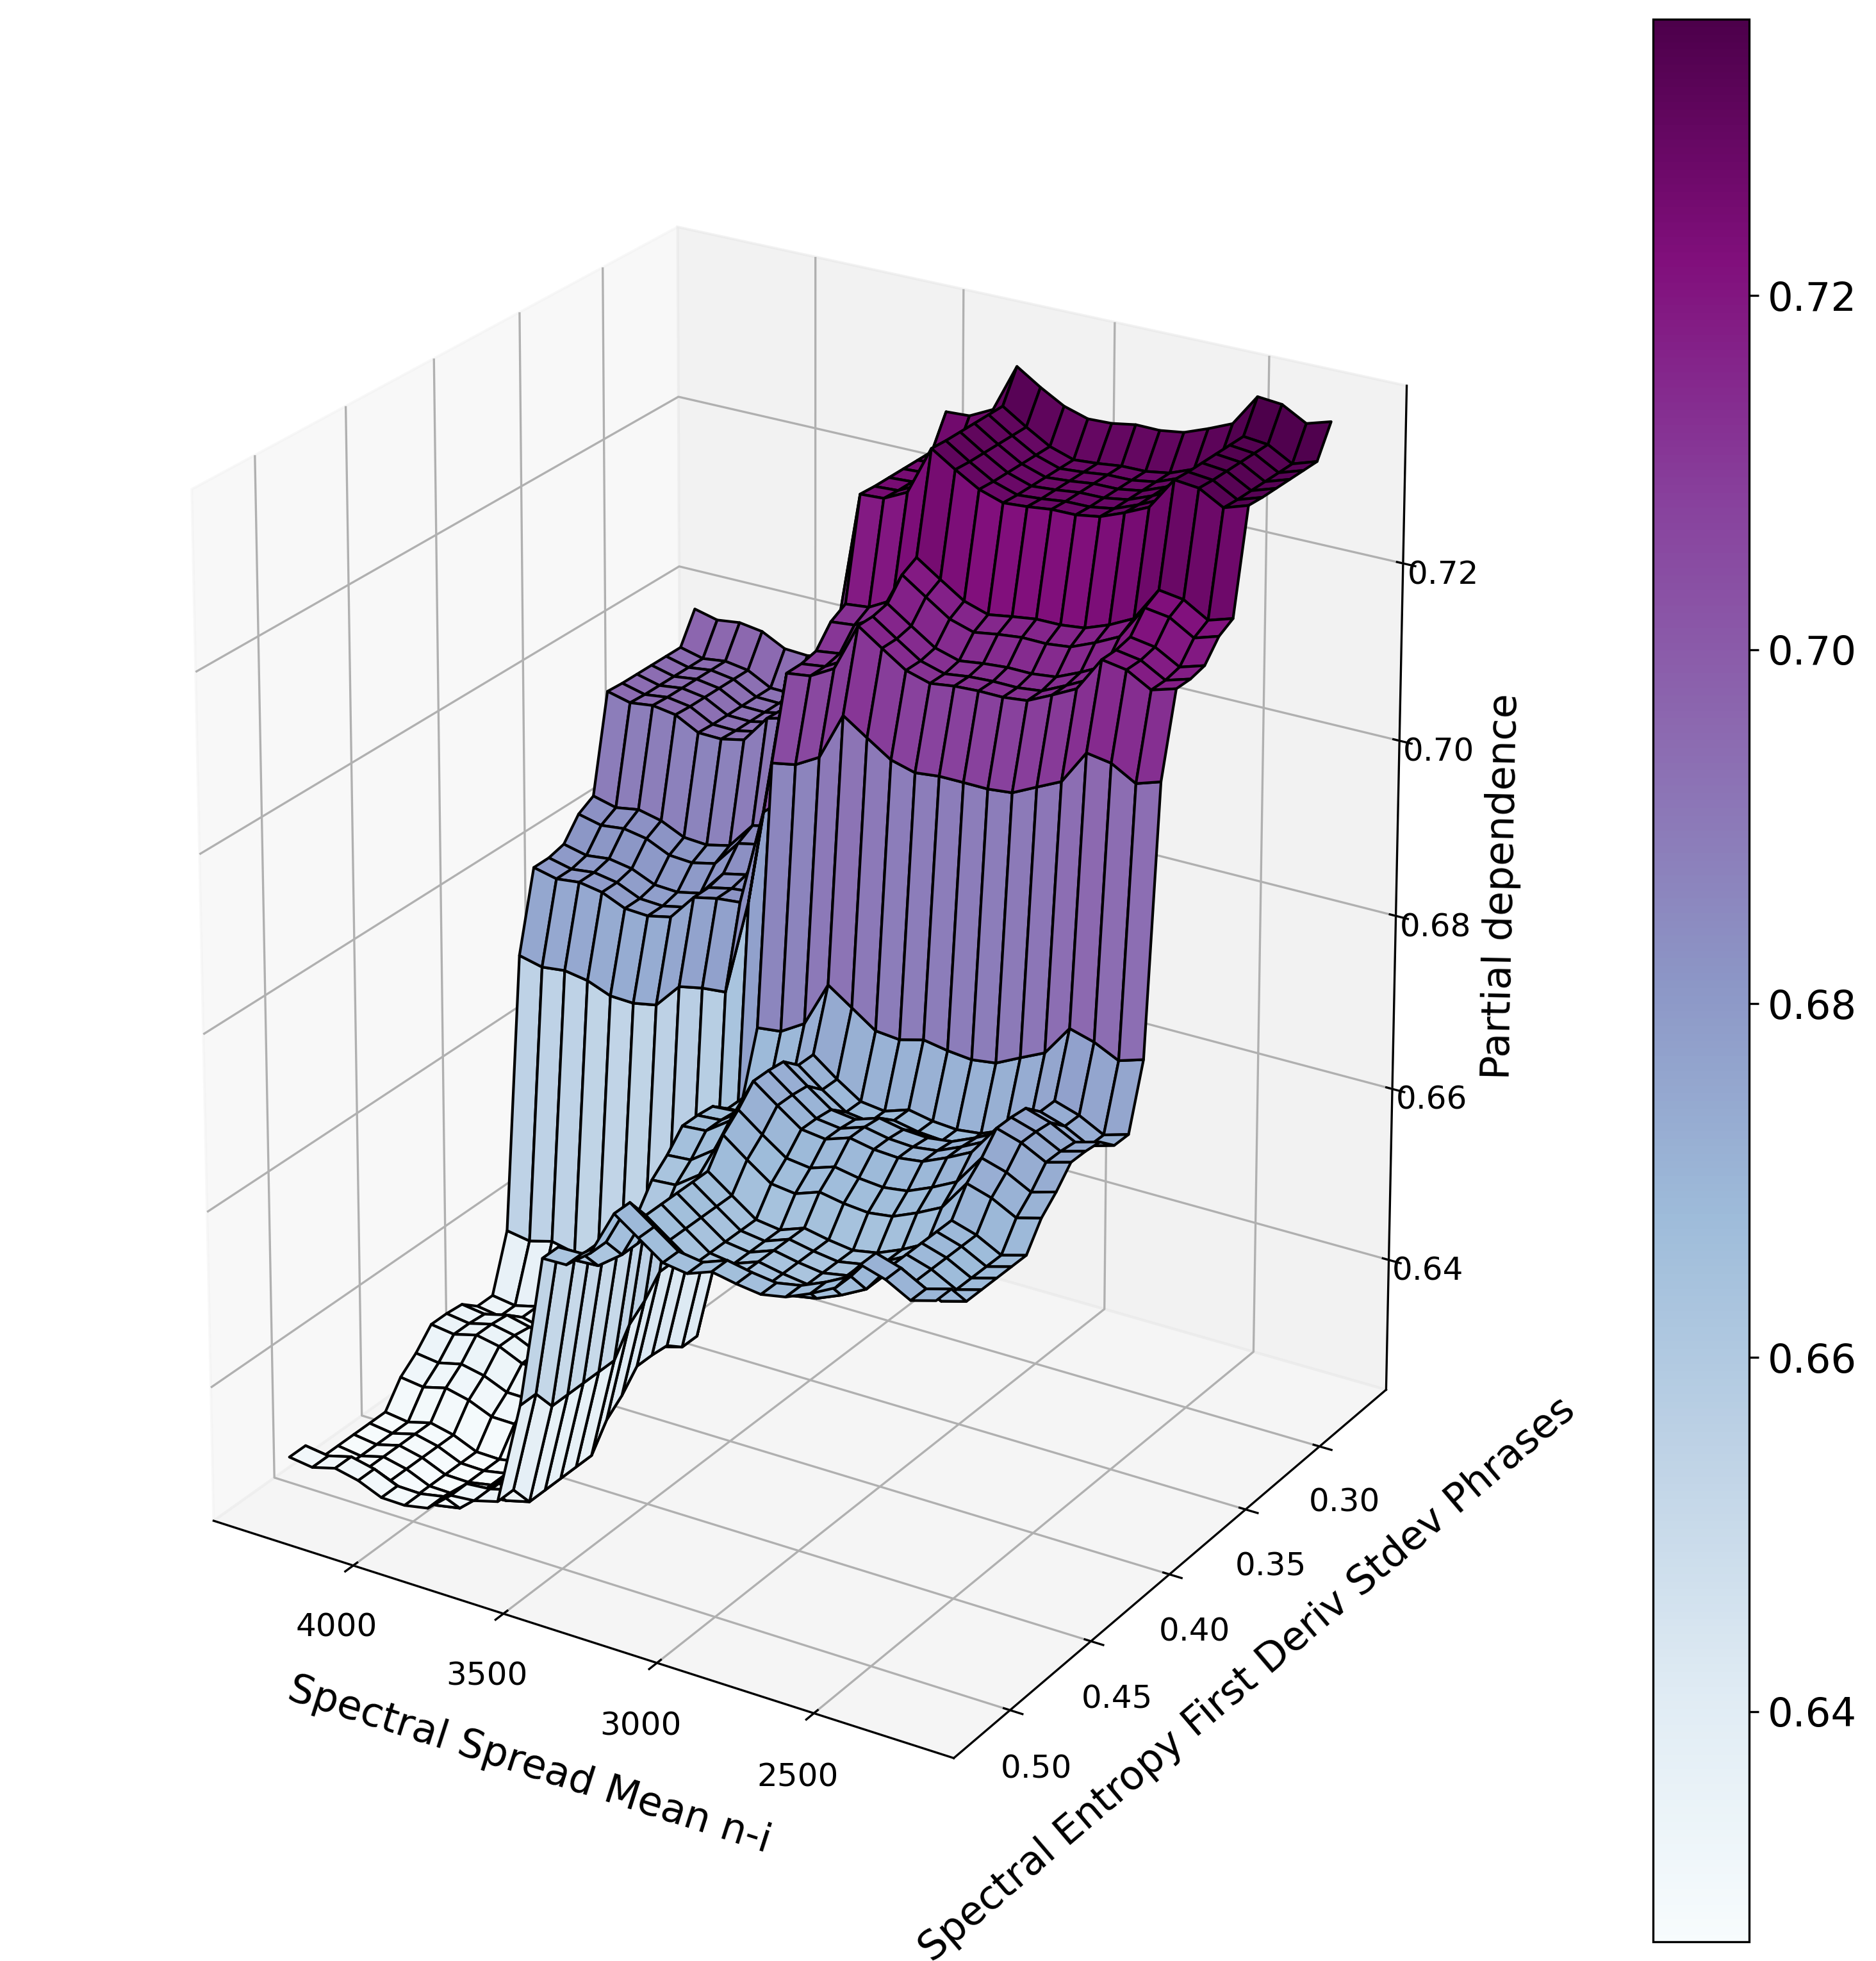

In [19]:
from sklearn.inspection import partial_dependence, plot_partial_dependence
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
rcParams['font.size'] = 15
fig = plt.figure()

features = ('Spectral Spread Mean n-i', 'Spectral Entropy First Deriv Stdev Phrases')
pdp = partial_dependence(
    tuned_clf, X_test, kind = 'average', features=features, grid_resolution=28
)

XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0], labelpad = 10)
ax.set_ylabel(features[1], labelpad = 10)
ax.set_zlabel('Partial dependence', labelpad = 10)

ax.view_init(elev=20, azim=122)
plt.colorbar(surf)

plt.subplots_adjust(top=0.9)
plt.show()

#### Evaluate performance of the classifier across demographics variables. Note: Only subsets that included at least 20 instances were kept for this analysis.

In [24]:
X = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\Complete_Feature_Set_11_19_2.csv')
y, age, sex, recording_num = X['y'], X['age'], X['sex'], X['recording_num']
X = X.drop(['recording_num','y'], axis = 1)

rfecv_subset = pd.read_csv(r'C:\Users\esabic\Desktop\Refactor_Attempts_11_4\Raw_Features_Complete_11_19\RFECV_Results_12_8.csv')
X = X.loc[:, rfecv_subset.columns]

corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
X = X.drop(X[to_drop], axis=1)
X = X.drop('high_indexphrase_features', axis = 1)
print('Total number of features dropped was...', num_feats_after - X.shape[1], '\nRemaining features... ', X.shape[1])

X = pd.concat([X, sex, age], axis = 1)

Total number of features dropped was... 30 
Remaining features...  74


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state = 42)

mask_s0 = (X_test['sex'] == 0)
mask_s1 = (X_test['sex'] == 1)

mask_s0_age_1 = ((X_test['sex'] == 0) & (X_test['age'] == 1)) 
mask_s0_age_2 = ((X_test['sex'] == 0) & (X_test['age'] == 2))
mask_s0_age_3 = ((X_test['sex'] == 0) & (X_test['age'] == 3))
mask_s0_age_4 = ((X_test['sex'] == 0) & (X_test['age'] == 4))
mask_s0_age_5 = ((X_test['sex'] == 0) & (X_test['age'] == 5))
mask_s0_age_6 = ((X_test['sex'] == 0) & (X_test['age'] == 6))
mask_s0_age_7 = ((X_test['sex'] == 0) & (X_test['age'] == 7))

mask_s1_age_2 = ((X_test['sex'] == 1) & (X_test['age'] == 2))
mask_s1_age_3 = ((X_test['sex'] == 1) & (X_test['age'] == 3))
mask_s1_age_4 = ((X_test['sex'] == 1) & (X_test['age'] == 4))
mask_s1_age_5 = ((X_test['sex'] == 1) & (X_test['age'] == 5))
mask_s1_age_6 = ((X_test['sex'] == 1) & (X_test['age'] == 6))
mask_s1_age_7 = ((X_test['sex'] == 1) & (X_test['age'] == 7))

X_train = X_train.drop(['sex','age'], axis = 1)
X_test = X_test.drop(['sex','age'], axis = 1)

In [26]:
from sklearn.metrics import roc_auc_score
print('sex: F, age: 10-19\n', classification_report(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_1], tuned_clf.predict(X_test[mask_s0_age_1])))

sex: F, age: 10-19
               precision    recall  f1-score   support

      benign     0.9500    0.7308    0.8261        26
   anomalous     0.2222    0.6667    0.3333         3

    accuracy                         0.7241        29
   macro avg     0.5861    0.6987    0.5797        29
weighted avg     0.8747    0.7241    0.7751        29

0.6987179487179488


In [27]:
print('sex: F, age: 20-29\n', classification_report(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_2], tuned_clf.predict(X_test[mask_s0_age_2])))

sex: F, age: 20-29
               precision    recall  f1-score   support

      benign     0.8182    0.8090    0.8136        89
   anomalous     0.5143    0.5294    0.5217        34

    accuracy                         0.7317       123
   macro avg     0.6662    0.6692    0.6676       123
weighted avg     0.7342    0.7317    0.7329       123

0.669200264375413


In [28]:
print('sex: F, age: 30-39\n', classification_report(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_3], tuned_clf.predict(X_test[mask_s0_age_3])))

sex: F, age: 30-39
               precision    recall  f1-score   support

      benign     0.4444    0.6667    0.5333         6
   anomalous     0.9412    0.8649    0.9014        37

    accuracy                         0.8372        43
   macro avg     0.6928    0.7658    0.7174        43
weighted avg     0.8719    0.8372    0.8500        43

0.7657657657657658


In [29]:
print('sex: F, age: 40-49\n', classification_report(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_4], tuned_clf.predict(X_test[mask_s0_age_4])))

sex: F, age: 40-49
               precision    recall  f1-score   support

      benign     0.1667    0.2500    0.2000         4
   anomalous     0.9167    0.8684    0.8919        38

    accuracy                         0.8095        42
   macro avg     0.5417    0.5592    0.5459        42
weighted avg     0.8452    0.8095    0.8260        42

0.5592105263157895


In [30]:
print('sex: F, age: 50-59\n', classification_report(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_5], tuned_clf.predict(X_test[mask_s0_age_5])))

sex: F, age: 50-59
               precision    recall  f1-score   support

      benign     0.5000    0.2500    0.3333         4
   anomalous     0.9400    0.9792    0.9592        48

    accuracy                         0.9231        52
   macro avg     0.7200    0.6146    0.6463        52
weighted avg     0.9062    0.9231    0.9110        52

0.6145833333333333


In [31]:
print('sex: F, age: 60-69\n', classification_report(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0_age_6], tuned_clf.predict(X_test[mask_s0_age_6])))

sex: F, age: 60-69
               precision    recall  f1-score   support

      benign     0.5000    1.0000    0.6667         1
   anomalous     1.0000    0.9750    0.9873        40

    accuracy                         0.9756        41
   macro avg     0.7500    0.9875    0.8270        41
weighted avg     0.9878    0.9756    0.9795        41

0.9875


In [32]:
print('sex: F, age: 70-79\n', classification_report(y_test[mask_s0_age_7], tuned_clf.predict(X_test[mask_s0_age_7]), digits = 4))

sex: F, age: 70-79
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        23

    accuracy                         1.0000        23
   macro avg     1.0000    1.0000    1.0000        23
weighted avg     1.0000    1.0000    1.0000        23



In [33]:
print('sex: M, age: 20-29\n', classification_report(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_2], tuned_clf.predict(X_test[mask_s1_age_2])))

sex: M, age: 20-29
               precision    recall  f1-score   support

      benign     0.8750    0.6222    0.7273        45
   anomalous     0.1905    0.5000    0.2759         8

    accuracy                         0.6038        53
   macro avg     0.5327    0.5611    0.5016        53
weighted avg     0.7717    0.6038    0.6591        53

0.5611111111111111


In [34]:
print('sex: M, age: 30-39\n', classification_report(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_3], tuned_clf.predict(X_test[mask_s1_age_3])))

sex: M, age: 30-39
               precision    recall  f1-score   support

      benign     0.7500    0.6429    0.6923        14
   anomalous     0.7368    0.8235    0.7778        17

    accuracy                         0.7419        31
   macro avg     0.7434    0.7332    0.7350        31
weighted avg     0.7428    0.7419    0.7392        31

0.7331932773109243


In [35]:
print('sex: M, age: 40-49\n', classification_report(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_4], tuned_clf.predict(X_test[mask_s1_age_4])))

sex: M, age: 40-49
               precision    recall  f1-score   support

      benign     0.6667    1.0000    0.8000         6
   anomalous     1.0000    0.8800    0.9362        25

    accuracy                         0.9032        31
   macro avg     0.8333    0.9400    0.8681        31
weighted avg     0.9355    0.9032    0.9098        31

0.94


In [36]:
print('sex: M, age: 50-59\n', classification_report(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_5], tuned_clf.predict(X_test[mask_s1_age_5])))

sex: M, age: 50-59
               precision    recall  f1-score   support

      benign     0.5000    0.4000    0.4444         5
   anomalous     0.9412    0.9600    0.9505        50

    accuracy                         0.9091        55
   macro avg     0.7206    0.6800    0.6975        55
weighted avg     0.9011    0.9091    0.9045        55

0.6799999999999999


In [37]:
print('sex: M, age: 60-69\n', classification_report(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1_age_6], tuned_clf.predict(X_test[mask_s1_age_6])))

sex: M, age: 60-69
               precision    recall  f1-score   support

      benign     1.0000    0.5000    0.6667         2
   anomalous     0.9804    1.0000    0.9901        50

    accuracy                         0.9808        52
   macro avg     0.9902    0.7500    0.8284        52
weighted avg     0.9811    0.9808    0.9777        52

0.75


In [38]:
print('sex: M, age: 70-79, note: only 1 class has support\n', classification_report(y_test[mask_s1_age_7], tuned_clf.predict(X_test[mask_s1_age_7]), digits = 4))

sex: M, age: 70-79, note: only 1 class has support
               precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        25

    accuracy                         1.0000        25
   macro avg     1.0000    1.0000    1.0000        25
weighted avg     1.0000    1.0000    1.0000        25



In [39]:
print('sex: F\n', classification_report(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s0], tuned_clf.predict(X_test[mask_s0])))

sex: F
               precision    recall  f1-score   support

      benign     0.7717    0.7481    0.7597       131
   anomalous     0.8553    0.8705    0.8628       224

    accuracy                         0.8254       355
   macro avg     0.8135    0.8093    0.8113       355
weighted avg     0.8244    0.8254    0.8248       355

0.8093136586695747


In [40]:
print('sex: M\n', classification_report(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1]), target_names = ['benign','anomalous'], digits = 4))
print(roc_auc_score(y_test[mask_s1], tuned_clf.predict(X_test[mask_s1])))

sex: M
               precision    recall  f1-score   support

      benign     0.7778    0.6533    0.7101        75
   anomalous     0.8660    0.9231    0.8936       182

    accuracy                         0.8444       257
   macro avg     0.8219    0.7882    0.8019       257
weighted avg     0.8402    0.8444    0.8401       257

0.7882051282051282


### Pickle the model for later use.

In [41]:
import pickle

pkl_filename = "GBC_1_25_.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(tuned_clf, file)